In [3]:
%cd ..

/Users/mateoibarguen/Desktop/DATA-Capstone


In [95]:
from models.networks.lstm_models import *
from models.spectra_preprocessor import *
from keras.utils import plot_model
import seaborn as sns
import math
import numpy as np

from tensorflow.keras import backend as k
from tensorflow.keras.layers import Layer
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

In [33]:
spectra_pp = SpectraPreprocessor(dataset_name='test', num_channels=10, num_instances=20, use_generator=False)
X_train, y_train, X_test, y_test = spectra_pp.transform(encoded=True)

In [57]:
class ChannelPadder(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(ChannelPadder, self).__init__(**kwargs)
        
    def transform_dimensions(self, dm, output_dim):
        result = dm
        nc = dm.shape[2]
        remainder = output_dim % nc
        for i in range(0, output_dim - 2*nc - 2, nc):
            paddings = [[0, 0], [0, 0], [0, nc]]
            result = tf.pad(result, paddings, 'SYMMETRIC')
        paddings = [[0, 0], [0, 0], [0, output_dim - result.shape[2]]]
        result = tf.pad(result, paddings, 'SYMMETRIC')
        return result 
    
    def call(self, X):
        return self.transform_dimensions(X, self.output_dim)   

In [58]:
class GoogleModel(BaseModel):

    def set_params_range(self):
        return {'conv_1': {'type': 'integer', 'min': 8, 'max': 64, 'default': 16},
                'conv_2': {'type': 'integer', 'min': 8, 'max': 64, 'default': 32},
                'bi_1': {'type': 'float', 'min': 8, 'max': 128, 'default': 128},
                'bi_2': {'type': 'integer', 'min': 8, 'max': 128, 'default': 128},
                'drop_1': {'type': 'float', 'min': 0, 'max': 1, 'default': 0.01},
                'dense_1': {'type': 'float', 'min': 8, 'max': 128, 'default': 64},
                'drop_2': {'type': 'float', 'min': 0, 'max': 1, 'default': 0.05}
                }

    def build_model(self, num_channels, num_timesteps, output_shape, params):
        """
        From: https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py

        """
        model = Sequential()
        model.add(ChannelPadder(num_channels))
        model.add(Conv1D(params['conv_1'], 5))
        model.add(BatchNormalization())
        model.add(Conv1D(params['conv_2'], 5))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(params['bi_1'], return_sequences=True)))
        model.add(Bidirectional(LSTM(params['bi_2'], return_sequences=True)))
        model.add(Attention(293))
        model.add(Dropout(params['drop_1']))
        model.add(Dense(params['dense_1'], activation='elu'))
        model.add(Dropout(params['drop_2']))
        model.add(Dense(output_shape, activation='softmax'))
        return model

In [59]:
g = GoogleModel(num_channels=50, num_timesteps=1001, output_shape=5)

In [60]:
baseline_model_compile_dict = {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics':['accuracy']}

In [61]:
g.fit(X_train, y_train, X_test, y_test, 64, 1, compile_dict=baseline_model_compile_dict)

Using default parameters: {'conv_1': 16, 'conv_2': 32, 'bi_1': 128, 'bi_2': 128, 'drop_1': 0.01, 'dense_1': 64, 'drop_2': 0.05}
Train on 16 samples, validate on 4 samples
15/15 [==============================] - 0s 7ms/sample - loss: 1.6199 - accuracy: 0.2667


In [69]:
spectra_pp = SpectraPreprocessor(dataset_name='test', num_channels=5, num_instances=20, use_generator=False)
X_train, y_train, X_test, y_test = spectra_pp.transform(encoded=True)

In [70]:
X_test.shape

(15, 301, 5)

In [71]:
g.evaluate(X_test, y_test)

15/15 [==============================] - 1s 71ms/sample - loss: 1.6203 - accuracy: 0.2667


{'metrics_names': ['loss', 'accuracy'],
 'metrics': [1.620252013206482, 0.2666666805744171]}

### Precision-recall curves

In [84]:
probs = g.keras_model.predict_proba(X_test)
probs_one = probs[:, 0]
y_true_one = y_test[:, 0]

In [96]:
fpr, tpr, _ = roc_curve(y_true_one, probs_one)
roc_auc = roc_auc_score(y_true_one, probs_one)

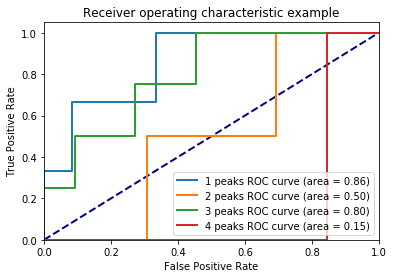

In [102]:
probs = g.keras_model.predict_proba(X_test)
num_peaks = 4
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

for i in range(num_peaks):
    probs_i = probs[:, i]
    y_true_i = y_test[:, i]
    fpr, tpr, _ = roc_curve(y_true_i, probs_i)
    roc_auc = roc_auc_score(y_true_i, probs_i)
    plt.plot(fpr, tpr,
         lw=lw, label='%d peaks ROC curve (area = %0.2f)' % (i + 1, roc_auc))
    plt.legend(loc='lower right')
    

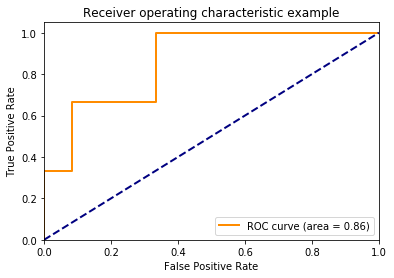

In [98]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
one_prob = 

In [65]:
preds = g.keras_model.predict(X_test)

In [11]:
import pandas as pd

In [12]:
num_peaks = pd.DataFrame()
num_peaks['prob'] = preds[0]
num_peaks['n_peaks'] = list(range(1, 6))

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def plot_predicted_prob(peak_probs, ax):
    num_peaks = list(range(1, len(peak_probs) + 1))
    ax.bar(num_peaks, peak_probs)
    ax.set_title('Predicted Probability for Num Peaks')
    ax.set_xlabel('Num Peaks')
    ax.set_ylabel('Probability')

In [29]:
def plot_predicted_probs(peaks_probs, num_plots=None):
    if num_plots is None:
        num_plots = peaks_probs.shape[0]
    fig, axes = plt.subplots(math.ceil(num_plots), 1, figsize=(7, 70))
    
    for i in range(num_plots):
        plot_predicted_prob(peaks_probs[i], axes[i])
        
    plt.subplots_adjust(hspace = 0.9)
    plt.show()

In [30]:
from sklearn.metrics import precision_recall_curve

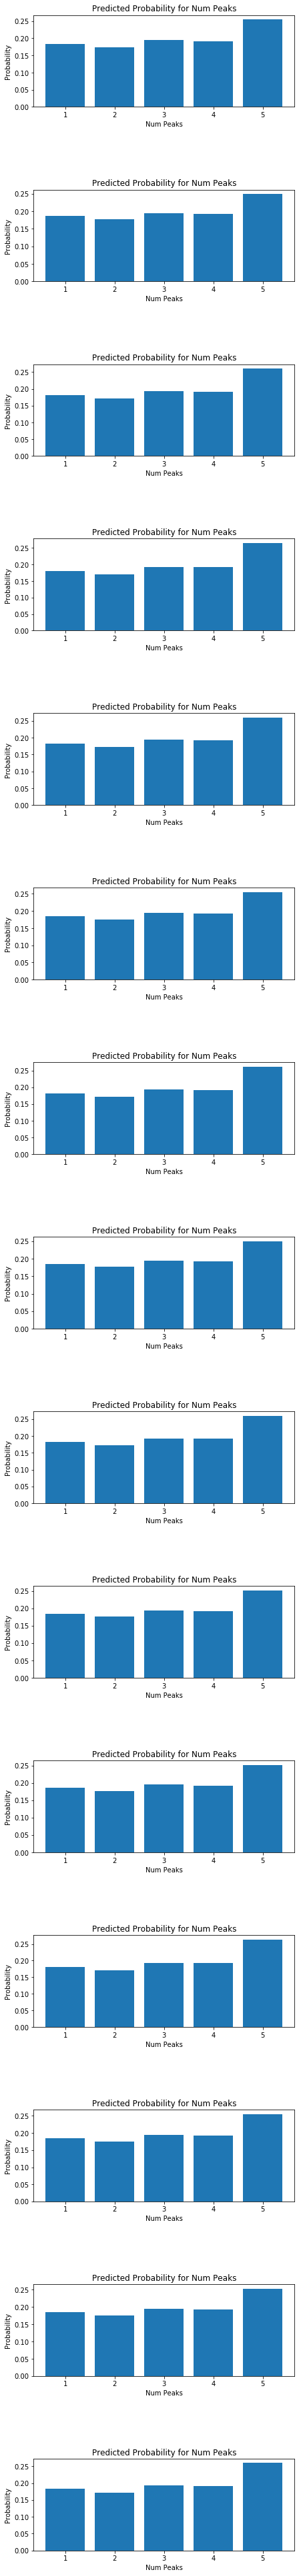

In [31]:
plot_predicted_probs(preds)

In [10]:
class GoogleModel(BaseModel):

    def set_params_range(self):
        return {'conv_1': {'type': 'integer', 'min': 8, 'max': 64, 'default': 16},
                'conv_2': {'type': 'integer', 'min': 8, 'max': 64, 'default': 32},
                'bi_1': {'type': 'float', 'min': 8, 'max': 128, 'default': 128},
                'bi_2': {'type': 'integer', 'min': 8, 'max': 128, 'default': 128},
                'drop_1': {'type': 'float', 'min': 0, 'max': 1, 'default': 0.01},
                'dense_1': {'type': 'float', 'min': 8, 'max': 128, 'default': 64},
                'drop_2': {'type': 'float', 'min': 0, 'max': 1, 'default': 0.05}
                }

    def build_model(self, num_channels, num_timesteps, output_shape, params):
        """
        From: https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py

        """
        model = Sequential()
        model.add(Conv1D(params['conv_1'], 5))
        model.add(BatchNormalization())
        model.add(Conv1D(params['conv_2'], 5))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(params['bi_1'], return_sequences=True)))
        model.add(Bidirectional(LSTM(params['bi_2'], return_sequences=True)))
        model.add(Attention(993))
        model.add(Dropout(params['drop_1']))
        model.add(Dense(params['dense_1'], activation='elu'))
        model.add(Dropout(params['drop_2']))
        model.add(Dense(output_shape, activation='softmax'))
        return model

In [11]:
g = GoogleModel(num_channels=10, num_timesteps=1001, output_shape=4)